In [1]:
from keras.preprocessing import image

target_img_path = 'moon_portrait.jpg'
style_reference_img_path = 'gogh_starry_night.jpg'

width, height = image.load_img(target_img_path).size

scaled_height = 400
scale_factor = scaled_height / height
scaled_width = int(width * scale_factor)
scaled_shape = (scaled_height, scaled_width)

print('Shape of scaled image =', scaled_shape)

Using TensorFlow backend.


Shape of scaled image = (400, 349)


In [2]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=scaled_shape)
    img = image.img_to_array(img)
    # Expand a axis of samples.
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Add pixel averages of ImageNet depthwisely.
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # Flip a format of image BGR to RGB.
    x = np.flip(x, axis=-1)
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
from keras import backend as K

n_channels = 3

target_image = K.constant(preprocess_image(target_img_path))
style_reference_image = K.constant(preprocess_image(style_reference_img_path))
combination_image = K.placeholder(shape=(1, scaled_height, scaled_width, n_channels))

In [4]:
# Make a input batch by concatenating target, style reference and generated image.
input_tensor = K.concatenate(tensors=[target_image,
                                      style_reference_image,
                                      combination_image],
                             axis=0)

idx_target, idx_style, idx_combination = (0, 1, 2)

In [5]:
# Load only convolutional layers, not classifier.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, pattern=(2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    '''
    Return a loss weight calculated by corelation of features of several layers.
    '''
    S = gram_matrix(style)
    C = gram_matrix(combination)
    n_channels = 3
    size = scaled_height * scaled_width
    return K.sum(K.square(S - C)) / (4. * (n_channels ** 2) * (size ** 2))

def total_variation_loss(x):
    '''
    Return a weight of space continuos.
    '''
    a = K.square(x[:, :scaled_height-1, :scaled_width-1, :] - x[:, 1:, :scaled_width-1, :])
    b = K.square(x[:, :scaled_height-1, :scaled_width-1, :] - x[:, :scaled_height-1, 1:, :])
    return K.sum(K.pow(a+b, 1.25))

In [8]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Calculate content loss
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[idx_target, :, :, :]
combination_features = layer_features[idx_combination, :, :, :]
loss = loss + content_weight * content_loss(base=target_image_features,
                                      combination=combination_features)

# Calculate style loss
for style_layer_name in style_layers:
    style_layer_features = outputs_dict[style_layer_name]
    style_reference_features = style_layer_features[idx_style, :, :, :]
    combination_features = style_layer_features[idx_combination, :, :, :]
    loss = loss + (style_weight / len(style_layers)) * style_loss(style=style_reference_features,
                                                                  combination=combination_features)

# Calculate total variation loss
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [9]:
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function(inputs=[combination_image], outputs=[loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        
        x = x.reshape((1, scaled_height, scaled_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grads_value = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grads_value = grads_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None

        grads_value = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_value

evaluator = Evaluator()

In [10]:
# Use a L-BFGS in scipy lib.
from scipy.optimize import fmin_l_bfgs_b
import time

suffix = target_img_path.split('.')[0]
result_prefix = 'neural_style_transfer_result'
iterations = 20

x = preprocess_image(target_img_path)
x = x.flatten()

img_results = []

for n in range(iterations):
    print('*' * 80)
    print('iteration =', n)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(func=evaluator.loss,
                                     x0=x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    print('current loss =', min_val)
    img = x.copy().reshape((scaled_height, scaled_width, n_channels))
    img = deprocess_image(img)
    img_fname = '%s_%s_at_iteration_%d.png' % (suffix, result_prefix, n)
    image.save_img(img_fname, img)
    img_results.append(img)
    end_time = time.time()
    print('%d iteration completed, result image=%s, time=%s' % (n, img_fname, (end_time-start_time)))
    

********************************************************************************
iteration = 0
current loss = 1351789800.0
0 iteration completed, result image=moon_portrait_neural_style_transfer_result_at_iteration_0.png, time=117.50793647766113
********************************************************************************
iteration = 1
current loss = 442573980.0
1 iteration completed, result image=moon_portrait_neural_style_transfer_result_at_iteration_1.png, time=115.05853343009949
********************************************************************************
iteration = 2
current loss = 289268770.0
2 iteration completed, result image=moon_portrait_neural_style_transfer_result_at_iteration_2.png, time=116.81776142120361
********************************************************************************
iteration = 3
current loss = 234706320.0
3 iteration completed, result image=moon_portrait_neural_style_transfer_result_at_iteration_3.png, time=115.13400101661682
*******************

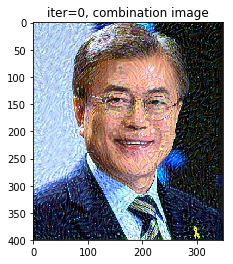

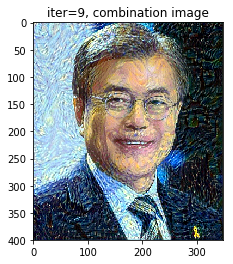

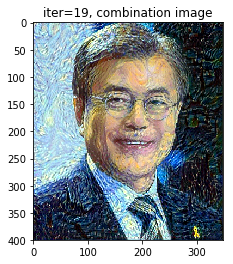

In [26]:
import matplotlib.pyplot as plt

for idx in [0, 9, 19]:
    title_msg = 'iter=%d, combination image' % idx
    plt.figure(title_msg)
    plt.title(title_msg)
    plt.imshow(img_results[idx])
    plt.show()